In [29]:
# 导入需要的模块
import tensorflow as tf # tensorflow模块，深度学习框架
import keras # keras模块，深度学习框架
import re # 正则表达式
import numpy as np # numpy数组
import pandas as pd # pandas表格
import matplotlib.pyplot as plt # matplotlib 数据可视化
from sklearn.model_selection import train_test_split # 训练集、验证集、测试集的划分
from itertools import product # 迭代工具
from tensorflow.keras.models import load_model # 用于加载模型
from sklearn.utils import class_weight # 用于计算样本的权重
from sklearn.metrics import roc_curve, auc # 用于绘画ROC曲线，计算AUC值
from keras.preprocessing.image import ImageDataGenerator # keras模块的图片预处理模块，可用于数据增强
from keras.optimizers import Adam # Adam优化器
from collections import Counter # 词频统计包
import time
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import RandomOverSampler

In [40]:
plt.style.use('ggplot') # 使用ggplot风格

def ROC(y_true,y_pre):#用于绘制ROC曲线
    fpr,tpr,threshold = roc_curve(y_true,y_pre,pos_label=1) #计算真正率和假正率
    roc_auc = auc(fpr,tpr) #计算auc的值

    plt.figure()
    lw = 2
    plt.figure(figsize=(10,10))
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc) #绘制ROC曲线
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--') #绘制直线y=x
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate',fontsize=20)
    plt.ylabel('True Positive Rate',fontsize=20)
    plt.title('ROC curve',fontsize=20)
    plt.legend(loc="lower right")
    plt.show()
def evaluate(model,text_test,label_test):
    predict_test = model.predict(text_test)
    ROC(list(label_test.flatten()),predict_test.flatten())

    y_true = list(label_test.flatten())
    y_pre = predict_test.flatten()
    fpr,tpr,threshold = roc_curve(y_true,y_pre,pos_label=1)
    data_val_model4 = pd.DataFrame(columns={'val':[]})
    data_val_model4['true']=label_test
    # 阈值的选择: fpr < 0.05
    for i in range(len(fpr)):
        if fpr[i] >= 0.05:
            index = i - 1
            break
    predict_threshold = threshold[index]
    predict_val = predict_test
    predict_class = np.zeros(len(text_test))
    print('开始预测')
    t0 = time.time()
    for i in range(len(text_test)):
        if predict_val[i] > predict_threshold:
            data_val_model4.loc[i,'val'] = 1
        else:
            data_val_model4.loc[i,'val'] = 0
    print("预测结束，耗时：%2s s"%(time.time()-t0))
    cf_matrix = confusion_matrix(data_val_model4['true'],data_val_model4['val'])
    TP = cf_matrix[0][0]#data_val_model4[(data_val_model4.true==1)&(data_val_model4.val==1)].shape[0]
    TN = cf_matrix[1][1]#data_val_model4[(data_val_model4.true==0)&(data_val_model4.val==0)].shape[0]
    FP = cf_matrix[0][1]#data_val_model4[(data_val_model4.true==0)&(data_val_model4.val==1)].shape[0]
    FN = cf_matrix[1][0]#data_val_model4[(data_val_model4.true==1)&(data_val_model4.val==0)].shape[0]
    print(cf_matrix)
    print("Accuracy: %3f"%((TP+TN)/(TP+TN+FP+FN)))
    print("Precision: %3f"%(TP/(TP+FP)))
    print("Recall: %3f"%((TP)/(TP+FN)))
    print("Specificity: %3f"%((TN)/(TN+FP)))
    print("Threshold: %3f"%predict_threshold)
    precision = TP/(TP+FP)
    recall = (TP)/(TP+FN)
    F1Score = 2*recall*precision/(recall+precision)
    print("F1-Score: %3f"%F1Score)

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
import pandas as pd
train_data = pd.read_csv('train_data.csv',encoding='ISO-8859-1')
test_data = pd.read_csv('test_data.csv',encoding='ISO-8859-1')
train_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,168ac3d396c7d588,if there is a chromosone then e=what is it?Sma...,0,0,0,0,0,0
1,168bc99fa2cfd9aa,Hollywood Undead \n\nI have collected articles...,0,0,0,0,0,0
2,168cd51c24508159,"""\n\n Rollback \n\nI've enabled rollback on yo...",0,0,0,0,0,0
3,168d515e2e99f78d,Another backlog. Thanks. (Trouble?/My Work),0,0,0,0,0,0
4,168d5a1c66f5e8bf,""" - unsigned\n\nWe do include it. This article...",0,0,0,0,0,0


In [5]:
# 处理测试集
test_labels = np.array(test_data['toxic'], dtype=np.int32)
t0 = time.time()
# 分词处理
test_intro_texts = []
for i,intro in enumerate(test_data['comment_text']):
    intro = intro.replace(',',' ').replace('.',' ').replace('\n',' ').replace('?',' ').replace('!',' ').replace(';',' ').replace(':',' ')
    intro = intro.replace('(',' ').replace(')',' ').replace('[',' ').replace(']',' ').replace('{',' ').replace('}',' ')
    intro = intro.replace('"',' ').replace('."',' ').replace('?"',' ').replace('!"',' ').replace('-','')
    intro = intro.replace('@','').replace('|','').replace('`','').replace('==','')
    intro = intro.lower()
    intro = [i for i in intro.split()]
    test_intro_texts.append(intro)
print("分词时间：%s"%(time.time()-t0))

分词时间：0.18849968910217285


In [6]:
train_data1 = train_data.sample(frac=0.2,axis=0)
train_data1.shape

(42675, 8)

In [7]:
# 处理训练集
train_labels = np.array(train_data1['toxic'], dtype=np.int32)#过采样用子集
#train_labels = np.array(train_data['toxic'], dtype=np.int32)#欠采样用全集
t0 = time.time()
# 分词处理
train_intro_texts = []
for intro in train_data1['comment_text']:#train_data['comment_text']
    intro = intro.replace(',',' ').replace('.',' ').replace('\n',' ').replace('?',' ').replace('!',' ').replace(';',' ').replace(':',' ')
    intro = intro.replace('(',' ').replace(')',' ').replace('[',' ').replace(']',' ').replace('{',' ').replace('}',' ')
    intro = intro.replace('"',' ').replace('."',' ').replace('?"',' ').replace('!"',' ').replace('-','').replace('==','')
    intro = intro.replace('@','').replace('|','').replace('`','')
    intro = intro.lower()
    intro = [i for i in intro.split()]
    train_intro_texts.append(intro)
print("分词时间：%s"%(time.time()-t0))

分词时间：1.0346646308898926


In [8]:
# 训练集，验证集，测试集的划分
# text_s,text_test_s,\
# label_s,label_test_s = train_test_split(
#     intro_texts,labels,
#     test_size=1.0, 
#     stratify=labels,
#     random_state=233)
text_train,text_val,\
label_train,label_val = train_test_split(
    train_intro_texts,train_labels,
    test_size=0.2, 
    stratify=train_labels,
    random_state=233)  # 训练集和验证集的划分
text_test = test_intro_texts
label_test = test_labels
print(text_train[0])
print(label_train[0])
print(len(text_train))
print(len(label_train))

['dear', 'contributors', 'please', 'read', 'vanniyar', 'puranam', 'based', 'on', 'one', 'of', 'the', '18', 'puranams', 'written', 'in', 'sanskrit', '&', 'subsequant', 'research', 'works', 'by', 'archeologists']
0
34140
34140


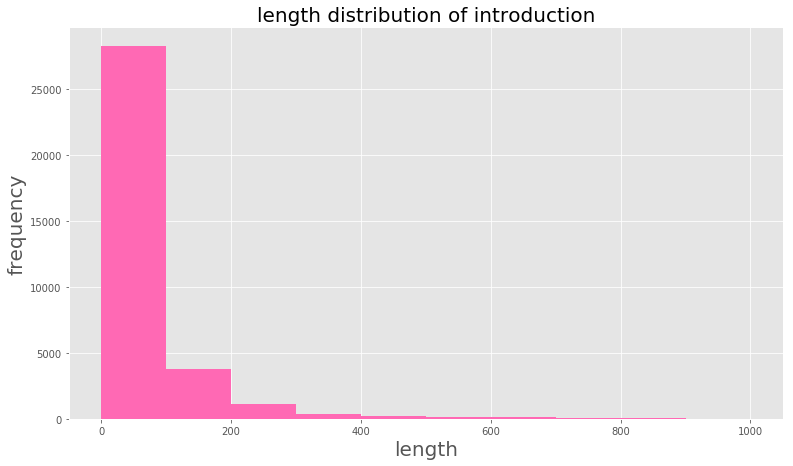

In [9]:
intro_lengths = [len(introduction) for introduction in text_train]#统计评论的长度

#绘制长度的直方图
fig,axe = plt.subplots(figsize=(12.8,7.2))
axe.hist(intro_lengths,bins=[0,100,200,300,400,500,600,700,800,900,1000],color="hotpink")
axe.set_title("length distribution of introduction",fontsize=20)
axe.set_xlabel("length",fontsize=20)
axe.set_ylabel("frequency",fontsize=20)
plt.show()

SENLEN = 400

# VOCAB_SIZE 的决定:训练集上该词出现的次数>=2
train_word_list = [word for sequence in text_train for word in sequence]
word_counter_introduction = Counter(train_word_list)#统计每个词出现的次数
most_common_word_in_train_introduction = word_counter_introduction.most_common()#词频降序排序
VOCAB_SIZE = len(most_common_word_in_train_introduction) + 1 # 设置一个初值，大概率结果不是这个
for i in range(len(most_common_word_in_train_introduction)):
    if most_common_word_in_train_introduction[i][1] <= 1:
        VOCAB_SIZE = i + 1 #VOCAB_SIZE设为词频>=2的词的数量
        break
        
# 对训练集建表
tokenizer = keras.preprocessing.text.Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(text_train)

# 将训练集的文本数字化
text_train = tokenizer.texts_to_sequences(text_train)
text_train = keras.preprocessing.sequence.pad_sequences(
    text_train, maxlen=SENLEN, padding='post')

# 将验证集的文本数字化
text_val = tokenizer.texts_to_sequences(text_val)
text_val = keras.preprocessing.sequence.pad_sequences(
    text_val, maxlen=SENLEN, padding='post')

# 将测试集的文本数字化
text_test = tokenizer.texts_to_sequences(text_test)
text_test = keras.preprocessing.sequence.pad_sequences(
    text_test, maxlen=SENLEN, padding='post')

## 随机过采样

In [46]:
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(text_train,label_train)
print(len(X_resampled))
print(len(text_train))

62168
34140


用Text-CNN测试结果

In [12]:
'''
model: text-cnn
'''
EMBED_SIZE = 128

# text-cnn
inp_text = keras.layers.Input(shape=(SENLEN,)) #输入，长度为SENLEN_TITLE
embed = keras.layers.Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=SENLEN,mask_zero=False)(inp_text)
cnn1 = keras.layers.Conv1D(128,1,padding='same', strides=1, activation='relu')(embed)
cnn1 = keras.layers.MaxPooling1D(pool_size=SENLEN)(cnn1)
cnn2 = keras.layers.Conv1D(128,2,padding='same', strides=1, activation='relu')(embed)
cnn2 = keras.layers.MaxPooling1D(pool_size=SENLEN)(cnn2)
cnn3 = keras.layers.Conv1D(128,3,padding='same', strides=1, activation='relu')(embed)
cnn3 = keras.layers.MaxPooling1D(pool_size=SENLEN)(cnn3)
x = keras.layers.concatenate([cnn1, cnn2, cnn3], axis=-1)
x = keras.layers.Flatten()(x)

x = keras.layers.Dense(256,activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(128,activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
preds=keras.layers.Dense(1,activation='sigmoid')(x) #预测层：二分类
model3=keras.Model(inputs=inp_text,outputs=preds)
model3.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 400, 128)     15609984    input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 400, 128)     16512       embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 400, 128)     32896       embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_3 (

In [45]:
model3 = load_model('model3.h5')#读入提前训练的模型

/root/miniconda3/envs/myconda/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [48]:
model3.compile(optimizer = tf.keras.optimizers.Adam(1e-4),loss = 'binary_crossentropy',metrics = ["accuracy"]) #损失函数是交叉熵，评价指标是准确率
#model2 = multi_gpu_model(model2, 2)  #GPU个数为2
early3_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0.0001, patience=5, mode='min') # 采用早停的策略
#tbCallBack = TensorBoard(log_dir="./model", histogram_freq=1,write_grads=True)
history = model3.fit(X_resampled, y_resampled,
    validation_data=[text_val,label_val],
    epochs=50,
    batch_size=512,
    callbacks=[early3_stopping],
    shuffle=True)
#model3.save('model3.h5')

/root/miniconda3/envs/myconda/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 62168 samples, validate on 8535 samples
Epoch 1/50
62168/62168 [==============================] - 11s 185us/step - loss: 0.8886 - acc: 0.6826 - val_loss: 0.4754 - val_acc: 0.7664
Epoch 2/50
62168/62168 [==============================] - 9s 142us/step - loss: 0.3229 - acc: 0.8676 - val_loss: 0.3368 - val_acc: 0.8562
Epoch 3/50
62168/62168 [==============================] - 9s 143us/step - loss: 0.1685 - acc: 0.9452 - val_loss: 0.2509 - val_acc: 0.9067
Epoch 4/50
62168/62168 [==============================] - 9s 143us/step - loss: 0.0928 - acc: 0.9756 - val_loss: 0.2235 - val_acc: 0.9216
Epoch 5/50
62168/62168 [==============================] - 9s 143us/step - loss: 0.0569 - acc: 0.9871 - val_loss: 0.2164 - val_acc: 0.9315
Epoch 6/50
62168/62168 [==============================] - 9s 142us/step - loss: 0.0380 - acc: 0.9924 - val_loss: 0.2164 - val_acc: 0.9340
Epoch 7/50
62168/62168 [==============================] - 9s 142us/step - loss: 0.0267 - acc: 0.9953 - val_loss: 0.2195 - 

<Figure size 432x288 with 0 Axes>

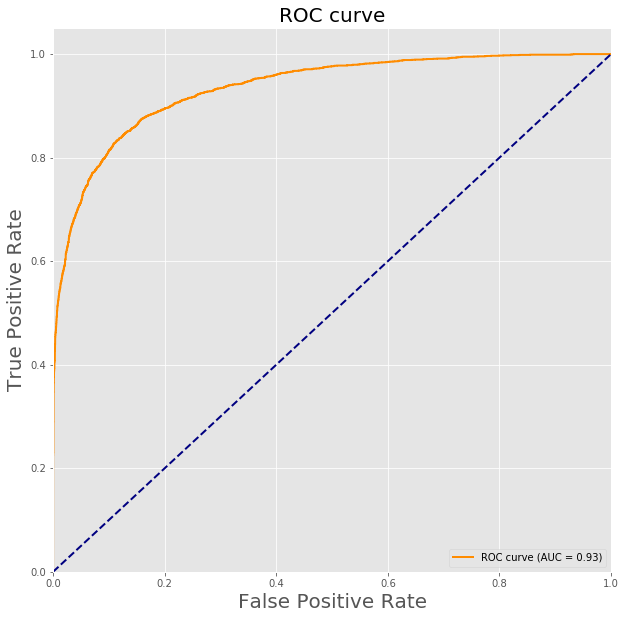

开始预测
预测结束，耗时：13.736560821533203 s
1803 7266 382 722
Accuracy: 0.891477
Precision: 0.825172
Recall: 0.714059
Specificity: 0.950052
Threshold: 0.091380
F1-Score: 0.765605


In [49]:
evaluate(model3,text_test,label_test)

## SMOTE

In [51]:
from imblearn.over_sampling import SMOTE, ADASYN
print('开始SMOTE')
t0 = time.time()
X_resampled_smote, y_resampled_smote = SMOTE().fit_sample(text_train,label_train)
print(sorted(Counter(y_resampled_smote).items()))
print('SMOTE结束，耗时： %2f s'%(time.time()-t0))

开始SMOTE
SMOTE结束，耗时： 6.170790 s


In [52]:
model3 = keras.models.load_model('model3.h5')#读入提前训练的模型

model3.compile(optimizer = Adam(1e-4),loss = 'binary_crossentropy',metrics = ["accuracy"]) #损失函数是交叉熵，评价指标是准确率
#model2 = multi_gpu_model(model2, 2)  #GPU个数为2
early3_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0.0001, patience=5, mode='min') # 采用早停的策略
#tbCallBack = TensorBoard(log_dir="./model", histogram_freq=1,write_grads=True)
history = model3.fit(X_resampled_smote, y_resampled_smote,
    validation_data=[text_val,label_val],
    epochs=50,
    batch_size=512,
    callbacks=[early3_stopping],
    shuffle=True)
#model3.save('model3.h5')

Train on 62168 samples, validate on 8535 samples
Epoch 1/50
62168/62168 [==============================] - 14s 227us/step - loss: 1.1359 - acc: 0.5334 - val_loss: 0.6800 - val_acc: 0.6265
Epoch 2/50
62168/62168 [==============================] - 11s 181us/step - loss: 0.6284 - acc: 0.6573 - val_loss: 0.6054 - val_acc: 0.6835
Epoch 3/50
62168/62168 [==============================] - 11s 181us/step - loss: 0.5153 - acc: 0.7497 - val_loss: 0.5151 - val_acc: 0.7288
Epoch 4/50
62168/62168 [==============================] - 11s 181us/step - loss: 0.3854 - acc: 0.8316 - val_loss: 0.4113 - val_acc: 0.7977
Epoch 5/50
62168/62168 [==============================] - 11s 181us/step - loss: 0.2800 - acc: 0.8853 - val_loss: 0.3786 - val_acc: 0.8224
Epoch 6/50
62168/62168 [==============================] - 11s 181us/step - loss: 0.2106 - acc: 0.9188 - val_loss: 0.3567 - val_acc: 0.8389
Epoch 7/50
62168/62168 [==============================] - 11s 181us/step - loss: 0.1615 - acc: 0.9424 - val_loss: 0.3

<Figure size 432x288 with 0 Axes>

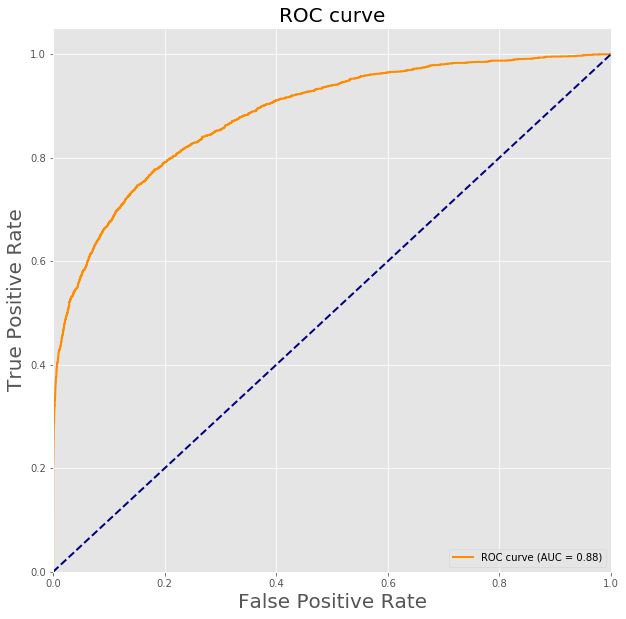

开始预测
预测结束，耗时：13.715039491653442 s
1443 7267 381 1082
Accuracy: 0.856188
Precision: 0.791118
Recall: 0.571485
Specificity: 0.950183
Threshold: 0.821328
F1-Score: 0.663601


In [53]:
evaluate(model3,text_test,label_test)

## ADASYN

In [54]:
from imblearn.over_sampling import SMOTE, ADASYN
print('开始ADASYN')
t0 = time.time()
X_resampled_adasyn, y_resampled_adasyn = ADASYN().fit_sample(text_train,label_train)
print(sorted(Counter(y_resampled_adasyn).items()))
print('ADASYN结束，耗时： %2f s'%(time.time()-t0))

开始ADASYN
[(0, 31084), (1, 29934)]
ADASYN结束，耗时： 87.636301 s


In [55]:
model3 = keras.models.load_model('model3.h5')#读入提前训练的模型

model3.compile(optimizer = Adam(1e-4),loss = 'binary_crossentropy',metrics = ["accuracy"]) #损失函数是交叉熵，评价指标是准确率
#model2 = multi_gpu_model(model2, 2)  #GPU个数为2
early3_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0.0001, patience=5, mode='min') # 采用早停的策略
#tbCallBack = TensorBoard(log_dir="./model", histogram_freq=1,write_grads=True)
history = model3.fit(X_resampled_adasyn, y_resampled_adasyn,
    validation_data=[text_val,label_val],
    epochs=50,
    batch_size=512,
    callbacks=[early3_stopping],
    shuffle=True)
#model3.save('model3.h5')

Train on 61018 samples, validate on 8535 samples
Epoch 1/50
61018/61018 [==============================] - 14s 231us/step - loss: 1.1385 - acc: 0.5371 - val_loss: 0.6514 - val_acc: 0.6707
Epoch 2/50
61018/61018 [==============================] - 11s 180us/step - loss: 0.6255 - acc: 0.6584 - val_loss: 0.6199 - val_acc: 0.6654
Epoch 3/50
61018/61018 [==============================] - 11s 181us/step - loss: 0.5140 - acc: 0.7488 - val_loss: 0.5426 - val_acc: 0.7090
Epoch 4/50
61018/61018 [==============================] - 11s 180us/step - loss: 0.3834 - acc: 0.8322 - val_loss: 0.4488 - val_acc: 0.7697
Epoch 5/50
61018/61018 [==============================] - 11s 180us/step - loss: 0.2794 - acc: 0.8850 - val_loss: 0.3858 - val_acc: 0.8157
Epoch 6/50
61018/61018 [==============================] - 11s 180us/step - loss: 0.2132 - acc: 0.9166 - val_loss: 0.3412 - val_acc: 0.8477
Epoch 7/50
61018/61018 [==============================] - 11s 181us/step - loss: 0.1647 - acc: 0.9414 - val_loss: 0.3

<Figure size 432x288 with 0 Axes>

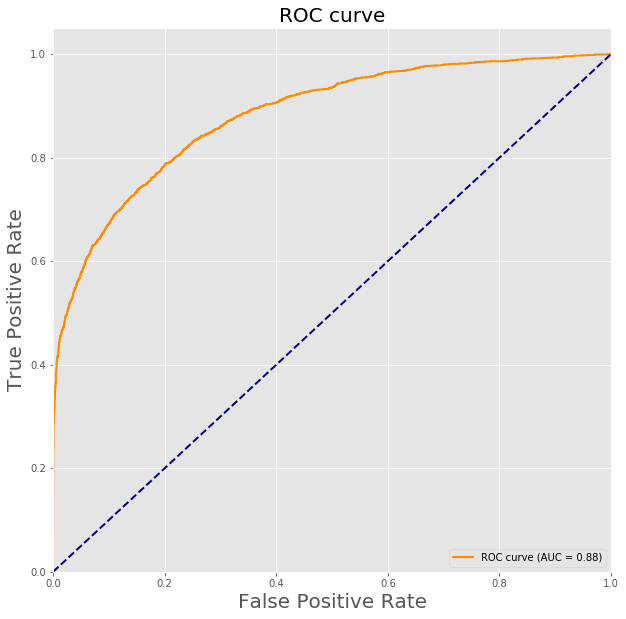

开始预测
预测结束，耗时：13.703115940093994 s
1458 7266 382 1067
Accuracy: 0.857564
Precision: 0.792391
Recall: 0.577426
Specificity: 0.950052
Threshold: 0.746811
F1-Score: 0.668041


In [56]:
evaluate(model3,text_test,label_test)

## SVM SMOTE

In [10]:
from imblearn.over_sampling import SVMSMOTE
print('开始SVMSMOTE')
t0 = time.time()
X_resampled_smote_svm, y_resampled_smote_svm = SVMSMOTE().fit_sample(text_train,label_train)
print(sorted(Counter(y_resampled_smote_svm).items()))
print('SVMSMOTE结束，耗时： %2f s'%(time.time()-t0))

开始SVMSMOTE
[(0, 31084), (1, 31084)]
SVMSMOTE结束，耗时： 1887.831128 s


In [57]:
model3 = keras.models.load_model('model3.h5')#读入提前训练的模型

model3.compile(optimizer = Adam(1e-4),loss = 'binary_crossentropy',metrics = ["accuracy"]) #损失函数是交叉熵，评价指标是准确率
#model2 = multi_gpu_model(model2, 2)  #GPU个数为2
early3_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0.0001, patience=5, mode='min') # 采用早停的策略
#tbCallBack = TensorBoard(log_dir="./model", histogram_freq=1,write_grads=True)
history = model3.fit(X_resampled_smote_svm, y_resampled_smote_svm,
    validation_data=[text_val,label_val],
    epochs=50,
    batch_size=512,
    callbacks=[early3_stopping],
    shuffle=True)
#model3.save('model3.h5')

Train on 62168 samples, validate on 8535 samples
Epoch 1/50
62168/62168 [==============================] - 14s 228us/step - loss: 1.0742 - acc: 0.5642 - val_loss: 0.5614 - val_acc: 0.7600
Epoch 2/50
62168/62168 [==============================] - 11s 177us/step - loss: 0.5238 - acc: 0.7469 - val_loss: 0.4743 - val_acc: 0.7759
Epoch 3/50
62168/62168 [==============================] - 11s 177us/step - loss: 0.3963 - acc: 0.8264 - val_loss: 0.3923 - val_acc: 0.8286
Epoch 4/50
62168/62168 [==============================] - 11s 177us/step - loss: 0.3009 - acc: 0.8747 - val_loss: 0.3343 - val_acc: 0.8576
Epoch 5/50
62168/62168 [==============================] - 11s 177us/step - loss: 0.2174 - acc: 0.9162 - val_loss: 0.3072 - val_acc: 0.8736
Epoch 6/50
62168/62168 [==============================] - 11s 177us/step - loss: 0.1621 - acc: 0.9405 - val_loss: 0.2997 - val_acc: 0.8798
Epoch 7/50
62168/62168 [==============================] - 11s 177us/step - loss: 0.1248 - acc: 0.9566 - val_loss: 0.2

<Figure size 432x288 with 0 Axes>

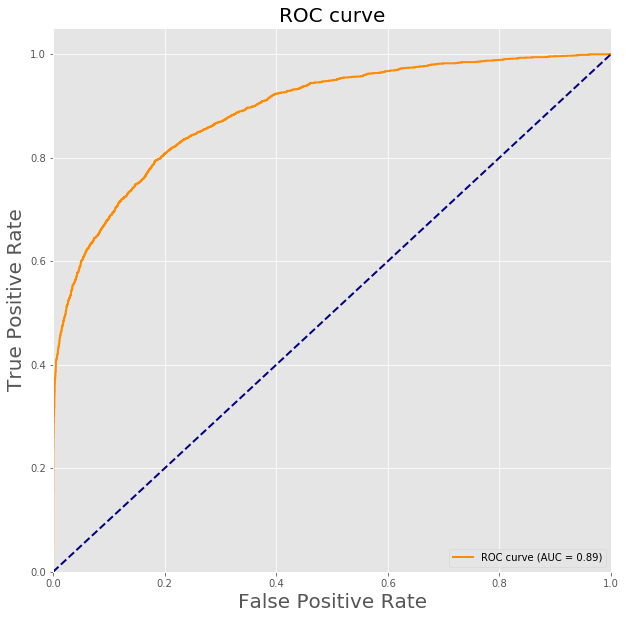

开始预测
预测结束，耗时：13.702888250350952 s
1510 7266 382 1015
Accuracy: 0.862676
Precision: 0.798097
Recall: 0.598020
Specificity: 0.950052
Threshold: 0.680781
F1-Score: 0.683722


In [58]:
evaluate(model3,text_test,label_test)

## 欠采样

### ClusterCentroids

给定数据集S, 原型生成算法将生成一个子集S’, 其中|S’| < |S|, 但是子集并非来自于原始数据集. 意思就是说: 原型生成方法将减少数据集的样本数量, 剩下的样本是由原始数据集生成的, 而不是直接来源于原始数据集.

ClusterCentroids函数实现了上述功能: 每一个类别的样本都会用K-Means算法的中心点来进行合成, 而不是随机从原始样本进行抽取.

In [13]:
from imblearn.under_sampling import ClusterCentroids#这里用的是样本子集train_data1
print('开始ClusterCentroids')
t0 = time.time()
cc = ClusterCentroids(random_state=0)
X_under_resampled_cl, y_under_resampled_cl = cc.fit_sample(text_train,label_train)
print(sorted(Counter(y_under_resampled_cl).items()))
print('ClusterCentroids结束，耗时： %2f s'%(time.time()-t0))

开始ClusterCentroids
[(0, 3056), (1, 3056)]
ClusterCentroids结束，耗时： 1681.496733 s


In [15]:
Counter(y_under_resampled_cl)

Counter({0: 3056, 1: 3056})

In [59]:
model3 = keras.models.load_model('model3.h5')#读入提前训练的模型

model3.compile(optimizer = Adam(1e-4),loss = 'binary_crossentropy',metrics = ["accuracy"]) #损失函数是交叉熵，评价指标是准确率
#model2 = multi_gpu_model(model2, 2)  #GPU个数为2
early3_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0.0001, patience=5, mode='min') # 采用早停的策略
#tbCallBack = TensorBoard(log_dir="./model", histogram_freq=1,write_grads=True)
history = model3.fit(X_under_resampled_cl, y_under_resampled_cl,
    validation_data=[text_val,label_val],
    epochs=50,
    batch_size=512,
    callbacks=[early3_stopping],
    shuffle=True)
#model3.save('model3.h5')

Train on 6112 samples, validate on 8535 samples
Epoch 1/50
6112/6112 [==============================] - 5s 763us/step - loss: 2.4571 - acc: 0.5088 - val_loss: 1.2714 - val_acc: 0.5834
Epoch 2/50
6112/6112 [==============================] - 1s 233us/step - loss: 1.3899 - acc: 0.5353 - val_loss: 1.0280 - val_acc: 0.6045
Epoch 3/50
6112/6112 [==============================] - 1s 233us/step - loss: 0.7713 - acc: 0.7088 - val_loss: 0.8946 - val_acc: 0.6203
Epoch 4/50
6112/6112 [==============================] - 1s 232us/step - loss: 0.4834 - acc: 0.8069 - val_loss: 1.0875 - val_acc: 0.5213
Epoch 5/50
6112/6112 [==============================] - 1s 233us/step - loss: 0.3403 - acc: 0.8639 - val_loss: 1.0728 - val_acc: 0.5302
Epoch 6/50
6112/6112 [==============================] - 1s 233us/step - loss: 0.2595 - acc: 0.9028 - val_loss: 1.1424 - val_acc: 0.5162
Epoch 7/50
6112/6112 [==============================] - 1s 233us/step - loss: 0.2096 - acc: 0.9272 - val_loss: 1.2720 - val_acc: 0.4852


<Figure size 432x288 with 0 Axes>

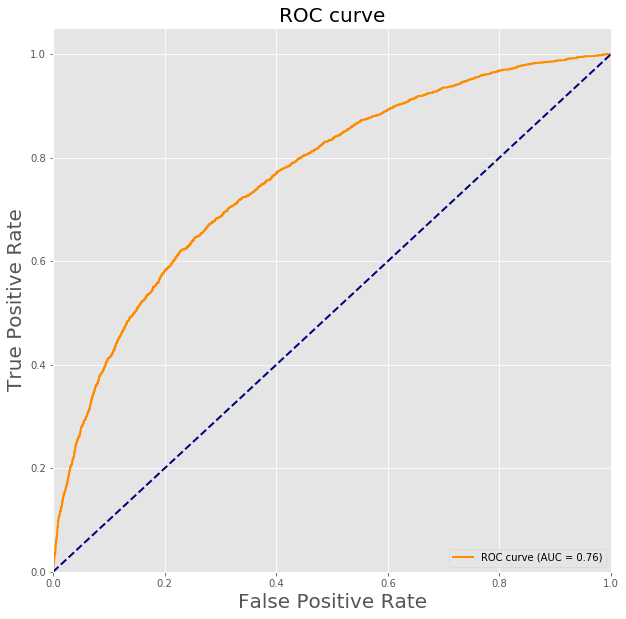

开始预测
预测结束，耗时：13.758186101913452 s
700 7267 381 1825
Accuracy: 0.783151
Precision: 0.647549
Recall: 0.277228
Specificity: 0.950183
Threshold: 0.976832
F1-Score: 0.388242


In [60]:
evaluate(model3,text_test,label_test)

### RandomUnderSampler

### Controlled under-sampling techniques
RandomUnderSampler函数是一种快速并十分简单的方式来平衡各个类别的数据: 随机选取数据的子集.

In [66]:
from imblearn.under_sampling import RandomUnderSampler
print('开始RandomUnderSampler')
t0 = time.time()
rus = RandomUnderSampler(random_state=0)
X_under_resampled_rd, y_under_resampled_rd = rus.fit_sample(text_train,label_train)
print(sorted(Counter(y_under_resampled_rd).items()))
print('RandomUnderSampler结束，耗时： %2f s'%(time.time()-t0))

开始RandomUnderSampler
[(0, 15087), (1, 15087)]
RandomUnderSampler结束，耗时： 0.087652 s


In [67]:
model3 = keras.models.load_model('model3.h5')#读入提前训练的模型

model3.compile(optimizer = Adam(1e-4),loss = 'binary_crossentropy',metrics = ["accuracy"]) #损失函数是交叉熵，评价指标是准确率
#model2 = multi_gpu_model(model2, 2)  #GPU个数为2
early3_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0.0001, patience=5, mode='min') # 采用早停的策略
#tbCallBack = TensorBoard(log_dir="./model", histogram_freq=1,write_grads=True)
history = model3.fit(X_under_resampled_rd, y_under_resampled_rd,
    validation_data=[text_val,label_val],
    epochs=50,
    batch_size=512,
    callbacks=[early3_stopping],
    shuffle=True)
#model3.save('model3.h5')

Train on 30174 samples, validate on 42676 samples
Epoch 1/50
30174/30174 [==============================] - 11s 354us/step - loss: 1.1898 - acc: 0.6189 - val_loss: 0.6338 - val_acc: 0.6792
Epoch 2/50
30174/30174 [==============================] - 7s 238us/step - loss: 0.5033 - acc: 0.7643 - val_loss: 0.4796 - val_acc: 0.7609
Epoch 3/50
30174/30174 [==============================] - 7s 238us/step - loss: 0.4107 - acc: 0.8181 - val_loss: 0.4343 - val_acc: 0.7890
Epoch 4/50
30174/30174 [==============================] - 7s 238us/step - loss: 0.3396 - acc: 0.8565 - val_loss: 0.3867 - val_acc: 0.8185
Epoch 5/50
30174/30174 [==============================] - 7s 238us/step - loss: 0.2752 - acc: 0.8898 - val_loss: 0.3710 - val_acc: 0.8345
Epoch 6/50
30174/30174 [==============================] - 7s 237us/step - loss: 0.2213 - acc: 0.9149 - val_loss: 0.3447 - val_acc: 0.8507
Epoch 7/50
30174/30174 [==============================] - 7s 237us/step - loss: 0.1741 - acc: 0.9385 - val_loss: 0.3279 -

<Figure size 432x288 with 0 Axes>

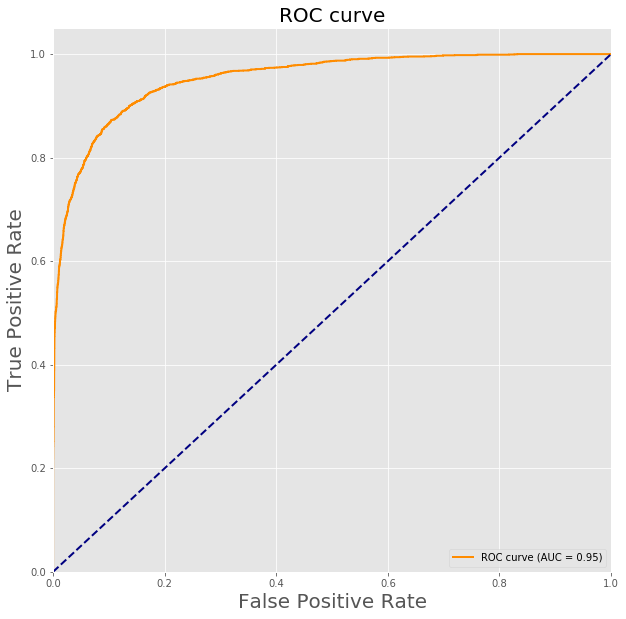

开始预测
预测结束，耗时：13.785406112670898 s
1959 7266 382 566
Accuracy: 0.906812
Precision: 0.836822
Recall: 0.775842
Specificity: 0.950052
Threshold: 0.861187
F1-Score: 0.805179


In [68]:
evaluate(model3,text_test,label_test)

XGBoost

In [69]:
print('开始RandomUnderSampler')
t0 = time.time()
rus = RandomUnderSampler(random_state=0,replacement=True)
X_under_resampled_rd_xgboost, y_under_resampled_rd_xgboost = rus.fit_sample(text_train,label_train)
print(sorted(Counter(y_under_resampled_rd_xgboost).items()))
print('RandomUnderSampler结束，耗时： %2f s'%(time.time()-t0))

开始RandomUnderSampler
[(0, 15087), (1, 15087)]
RandomUnderSampler结束，耗时： 0.124273 s


In [70]:
model3 = keras.models.load_model('model3.h5')#读入提前训练的模型

model3.compile(optimizer = Adam(1e-4),loss = 'binary_crossentropy',metrics = ["accuracy"]) #损失函数是交叉熵，评价指标是准确率
#model2 = multi_gpu_model(model2, 2)  #GPU个数为2
early3_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0.0001, patience=5, mode='min') # 采用早停的策略
#tbCallBack = TensorBoard(log_dir="./model", histogram_freq=1,write_grads=True)
history = model3.fit(X_under_resampled_rd_xgboost, y_under_resampled_rd_xgboost,
    validation_data=[text_val,label_val],
    epochs=50,
    batch_size=512,
    callbacks=[early3_stopping],
    shuffle=True)
#model3.save('model3.h5')

Train on 30174 samples, validate on 42676 samples
Epoch 1/50
30174/30174 [==============================] - 11s 361us/step - loss: 1.2079 - acc: 0.6181 - val_loss: 0.6276 - val_acc: 0.6835
Epoch 2/50
30174/30174 [==============================] - 7s 238us/step - loss: 0.5032 - acc: 0.7620 - val_loss: 0.4619 - val_acc: 0.7731
Epoch 3/50
30174/30174 [==============================] - 7s 237us/step - loss: 0.4107 - acc: 0.8170 - val_loss: 0.4240 - val_acc: 0.7964
Epoch 4/50
30174/30174 [==============================] - 7s 238us/step - loss: 0.3370 - acc: 0.8571 - val_loss: 0.3876 - val_acc: 0.8189
Epoch 5/50
30174/30174 [==============================] - 7s 237us/step - loss: 0.2709 - acc: 0.8897 - val_loss: 0.3620 - val_acc: 0.8383
Epoch 6/50
30174/30174 [==============================] - 7s 237us/step - loss: 0.2142 - acc: 0.9189 - val_loss: 0.3413 - val_acc: 0.8535
Epoch 7/50
30174/30174 [==============================] - 7s 238us/step - loss: 0.1705 - acc: 0.9396 - val_loss: 0.3353 -

<Figure size 432x288 with 0 Axes>

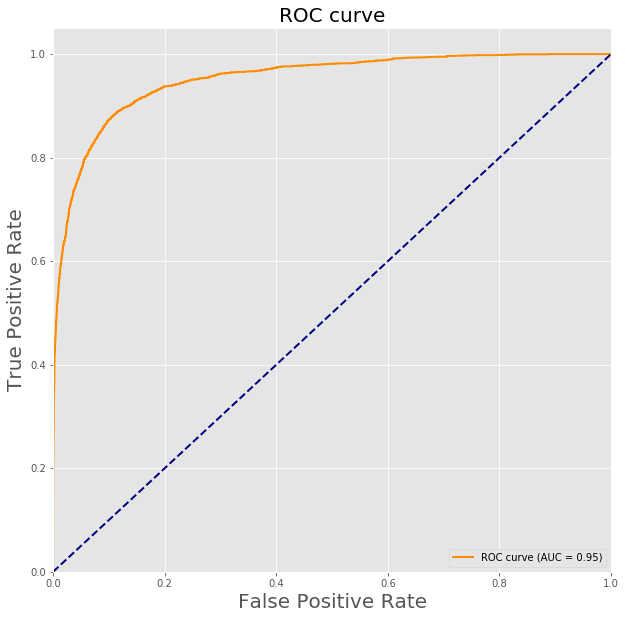

开始预测
预测结束，耗时：13.775056600570679 s
1958 7266 382 567
Accuracy: 0.906714
Precision: 0.836752
Recall: 0.775446
Specificity: 0.950052
Threshold: 0.875562
F1-Score: 0.804933


In [71]:
evaluate(model3,text_test,label_test)

### Cleaning under-sampling techniques

EditedNearestNeighbours

EditedNearestNeighbours这种方法应用最近邻算法来编辑(edit)数据集, 找出那些与邻居不太友好的样本然后移除. 对于每一个要进行下采样的样本, 那些不满足一些准则的样本将会被移除; 他们的绝大多数(kind_sel='mode')或者全部(kind_sel='all')的近邻样本都属于同一个类, 这些样本会被保留在数据集中.

In [43]:
from imblearn.under_sampling import EditedNearestNeighbours#这里用子集
print('开始EditedNearestNeighbours')
t0 = time.time()
enn = EditedNearestNeighbours()
X_resampled_Edi, y_resampled_Edi = enn.fit_sample(text_train,label_train)
print(sorted(Counter(y_resampled_Edi).items()))
print('EditedNearestNeighbours结束，耗时： %2f s'%(time.time()-t0))

开始EditedNearestNeighbours
[(0, 22937), (1, 3039)]
EditedNearestNeighbours结束，耗时： 626.856799 s


In [44]:
model3 = keras.models.load_model('model3.h5')#读入提前训练的模型

model3.compile(optimizer = Adam(1e-4),loss = 'binary_crossentropy',metrics = ["accuracy"]) #损失函数是交叉熵，评价指标是准确率
#model2 = multi_gpu_model(model2, 2)  #GPU个数为2
early3_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0.0001, patience=5, mode='min') # 采用早停的策略
#tbCallBack = TensorBoard(log_dir="./model", histogram_freq=1,write_grads=True)
history = model3.fit(X_resampled_Edi, y_resampled_Edi,
    validation_data=[text_val,label_val],
    epochs=50,
    batch_size=512,
    callbacks=[early3_stopping],
    shuffle=True)
#model3.save('model3.h5')

Train on 25976 samples, validate on 8535 samples
Epoch 1/50
25976/25976 [==============================] - 6s 241us/step - loss: 0.5297 - acc: 0.8525 - val_loss: 0.2893 - val_acc: 0.9040
Epoch 2/50
25976/25976 [==============================] - 4s 159us/step - loss: 0.3076 - acc: 0.8860 - val_loss: 0.2568 - val_acc: 0.9092
Epoch 3/50
25976/25976 [==============================] - 4s 159us/step - loss: 0.2669 - acc: 0.8943 - val_loss: 0.2360 - val_acc: 0.9131
Epoch 4/50
25976/25976 [==============================] - 4s 156us/step - loss: 0.2265 - acc: 0.9077 - val_loss: 0.2158 - val_acc: 0.9192
Epoch 5/50
25976/25976 [==============================] - 4s 159us/step - loss: 0.1847 - acc: 0.9247 - val_loss: 0.2009 - val_acc: 0.9234
Epoch 6/50
25976/25976 [==============================] - 4s 159us/step - loss: 0.1447 - acc: 0.9417 - val_loss: 0.1888 - val_acc: 0.9286
Epoch 7/50
25976/25976 [==============================] - 4s 160us/step - loss: 0.1111 - acc: 0.9565 - val_loss: 0.1834 - v

<Figure size 432x288 with 0 Axes>

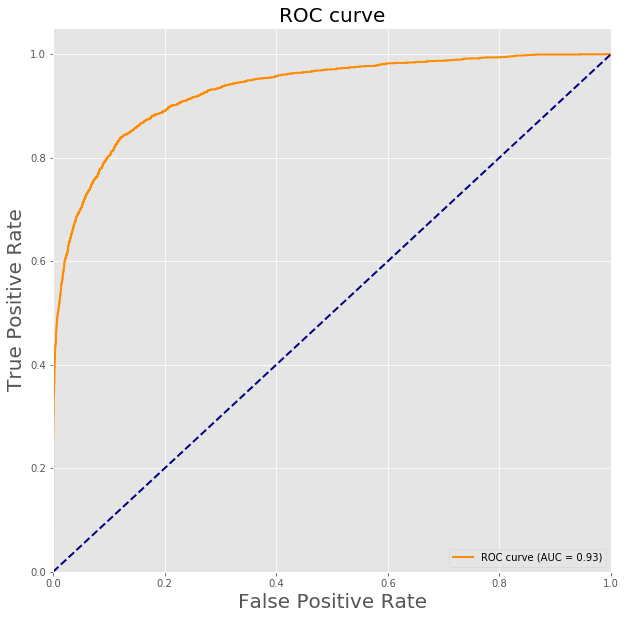

开始预测
预测结束，耗时：14.003849506378174 s
[[7266  382]
 [ 754 1771]]
Accuracy: 0.888332
Precision: 0.950052
Recall: 0.905985
Specificity: 0.822573
Threshold: 0.222971
F1-Score: 0.927496


In [45]:
evaluate(model3,text_test,label_test)

RepeatedEditedNearestNeighbours

重复基础的EditedNearestNeighbours算法多次.

In [46]:
from imblearn.under_sampling import RepeatedEditedNearestNeighbours#这里用子集
print('开始RepeatedEditedNearestNeighbours')
t0 = time.time()
enn = RepeatedEditedNearestNeighbours()
X_resampled_reEdi, y_resampled_reEdi = enn.fit_sample(text_train,label_train)
print(sorted(Counter(y_resampled_reEdi).items()))
print('RepeatedEditedNearestNeighbours结束，耗时： %2f s'%(time.time()-t0))

开始RepeatedEditedNearestNeighbours
[(0, 17458), (1, 3039)]
RepeatedEditedNearestNeighbours结束，耗时： 4099.708430 s


In [47]:
model3 = keras.models.load_model('model3.h5')#读入提前训练的模型

model3.compile(optimizer = Adam(1e-4),loss = 'binary_crossentropy',metrics = ["accuracy"]) #损失函数是交叉熵，评价指标是准确率
#model2 = multi_gpu_model(model2, 2)  #GPU个数为2
early3_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0.0001, patience=5, mode='min') # 采用早停的策略
#tbCallBack = TensorBoard(log_dir="./model", histogram_freq=1,write_grads=True)
history = model3.fit(X_resampled_reEdi, y_resampled_reEdi,
    validation_data=[text_val,label_val],
    epochs=50,
    batch_size=512,
    callbacks=[early3_stopping],
    shuffle=True)
#model3.save('model3.h5')

Train on 20497 samples, validate on 8535 samples
Epoch 1/50
20497/20497 [==============================] - 5s 249us/step - loss: 0.6941 - acc: 0.8080 - val_loss: 0.3253 - val_acc: 0.8902
Epoch 2/50
20497/20497 [==============================] - 3s 160us/step - loss: 0.3652 - acc: 0.8579 - val_loss: 0.2726 - val_acc: 0.9040
Epoch 3/50
20497/20497 [==============================] - 3s 162us/step - loss: 0.3167 - acc: 0.8687 - val_loss: 0.2535 - val_acc: 0.9065
Epoch 4/50
20497/20497 [==============================] - 3s 159us/step - loss: 0.2754 - acc: 0.8843 - val_loss: 0.2373 - val_acc: 0.9092
Epoch 5/50
20497/20497 [==============================] - 3s 162us/step - loss: 0.2338 - acc: 0.9026 - val_loss: 0.2299 - val_acc: 0.9094
Epoch 6/50
20497/20497 [==============================] - 3s 162us/step - loss: 0.1949 - acc: 0.9185 - val_loss: 0.2171 - val_acc: 0.9122
Epoch 7/50
20497/20497 [==============================] - 3s 162us/step - loss: 0.1569 - acc: 0.9379 - val_loss: 0.2140 - v

<Figure size 432x288 with 0 Axes>

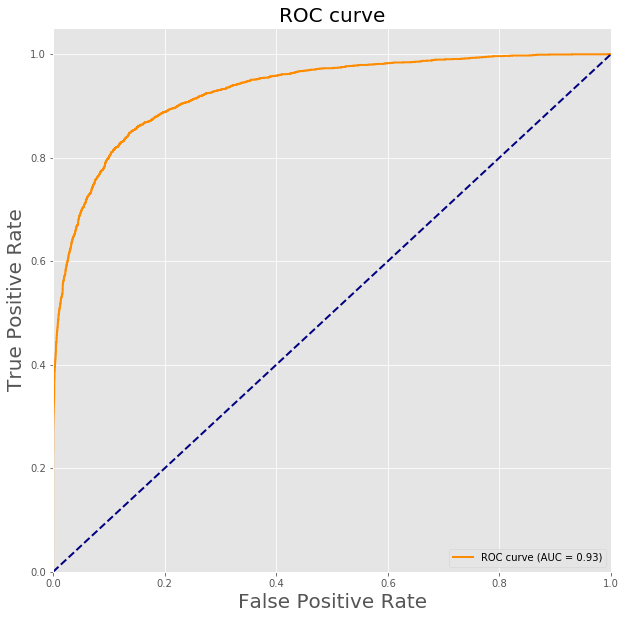

开始预测
预测结束，耗时：13.904752731323242 s
[[7267  381]
 [ 770 1755]]
Accuracy: 0.886857
Precision: 0.950183
Recall: 0.904193
Specificity: 0.821629
Threshold: 0.342169
F1-Score: 0.926618


In [48]:
evaluate(model3,text_test,label_test)

## 过采样和欠采样结合

SMOTEENN

In [39]:
from imblearn.combine import SMOTEENN#这里用子集
print('开始SMOTEENN')
t0 = time.time()
smote_enn = SMOTEENN(random_state=0)
X_resampled_SMOTEENN, y_resampled_SMOTEENN = smote_enn.fit_sample(text_train,label_train) 
print(sorted(Counter(y_resampled_SMOTEENN).items()))
print('SMOTEENNr结束，耗时： %2f s'%(time.time()-t0))

开始SMOTEENN
[(0, 16378), (1, 29495)]
SMOTEENNr结束，耗时： 2043.796413 s


In [72]:
model3 = keras.models.load_model('model3.h5')#读入提前训练的模型

model3.compile(optimizer = Adam(1e-4),loss = 'binary_crossentropy',metrics = ["accuracy"]) #损失函数是交叉熵，评价指标是准确率
#model2 = multi_gpu_model(model2, 2)  #GPU个数为2
early3_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0.0001, patience=5, mode='min') # 采用早停的策略
#tbCallBack = TensorBoard(log_dir="./model", histogram_freq=1,write_grads=True)
history = model3.fit(X_resampled_SMOTEENN, y_resampled_SMOTEENN,
    validation_data=[text_val,label_val],
    epochs=50,
    batch_size=512,
    callbacks=[early3_stopping],
    shuffle=True)
#model3.save('model3.h5')

Train on 45873 samples, validate on 42676 samples
Epoch 1/50
45873/45873 [==============================] - 15s 336us/step - loss: 1.3900 - acc: 0.5514 - val_loss: 1.0417 - val_acc: 0.2095
Epoch 2/50
45873/45873 [==============================] - 10s 217us/step - loss: 0.6195 - acc: 0.6648 - val_loss: 0.9990 - val_acc: 0.2515
Epoch 3/50
45873/45873 [==============================] - 10s 216us/step - loss: 0.5558 - acc: 0.7329 - val_loss: 0.9940 - val_acc: 0.4203
Epoch 4/50
45873/45873 [==============================] - 10s 217us/step - loss: 0.4603 - acc: 0.7994 - val_loss: 0.9985 - val_acc: 0.4798
Epoch 5/50
45873/45873 [==============================] - 10s 217us/step - loss: 0.3636 - acc: 0.8524 - val_loss: 1.0151 - val_acc: 0.5003
Epoch 6/50
45873/45873 [==============================] - 10s 217us/step - loss: 0.2797 - acc: 0.8944 - val_loss: 1.1258 - val_acc: 0.4865
Epoch 7/50
45873/45873 [==============================] - 10s 217us/step - loss: 0.2166 - acc: 0.9213 - val_loss: 1.

<Figure size 432x288 with 0 Axes>

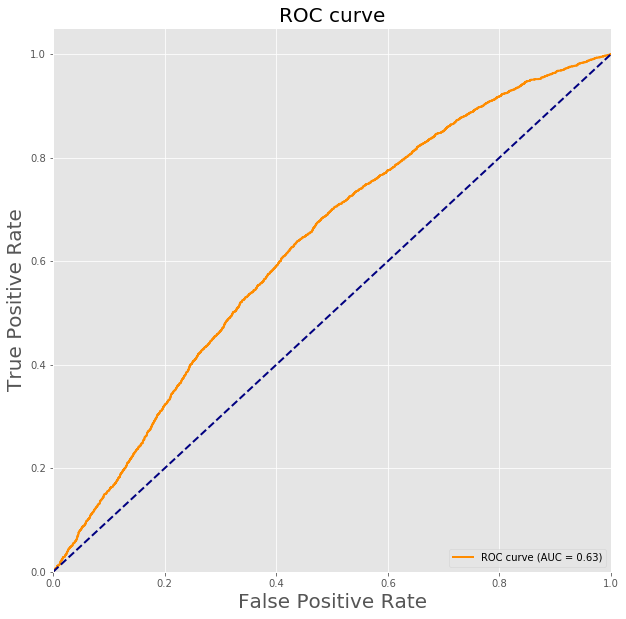

开始预测
预测结束，耗时：13.77644157409668 s
205 7267 381 2320
Accuracy: 0.734493
Precision: 0.349829
Recall: 0.081188
Specificity: 0.950183
Threshold: 0.977866
F1-Score: 0.131790


In [73]:
evaluate(model3,text_test,label_test)

SMOTETomek

In [10]:
from imblearn.combine import SMOTETomek#这里用子集
print('开始SMOTETomek')
t0 = time.time()
smote_tomek = SMOTETomek(random_state=0)
X_resampled_SMOTETomek, y_resampled_SMOTETomek = smote_tomek.fit_sample(text_train,label_train)
print(sorted(Counter(y_resampled_SMOTETomek).items()))
print('SMOTETomek结束，耗时： %2f s'%(time.time()-t0))

开始SMOTETomek
[(0, 30918), (1, 30918)]
SMOTETomek结束，耗时： 1578.984668 s


In [12]:
model3 = keras.models.load_model('model3.h5')#读入提前训练的模型

model3.compile(optimizer = Adam(1e-4),loss = 'binary_crossentropy',metrics = ["accuracy"]) #损失函数是交叉熵，评价指标是准确率
#model2 = multi_gpu_model(model2, 2)  #GPU个数为2
early3_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0.0001, patience=5, mode='min') # 采用早停的策略
#tbCallBack = TensorBoard(log_dir="./model", histogram_freq=1,write_grads=True)
history = model3.fit(X_resampled_SMOTETomek, y_resampled_SMOTETomek,
    validation_data=[text_val,label_val],
    epochs=50,
    batch_size=512,
    callbacks=[early3_stopping],
    shuffle=True)
#model3.save('model3.h5')

Train on 61836 samples, validate on 8535 samples
Epoch 1/50
61836/61836 [==============================] - 13s 212us/step - loss: 1.1339 - acc: 0.5297 - val_loss: 0.6681 - val_acc: 0.6558
Epoch 2/50
61836/61836 [==============================] - 9s 148us/step - loss: 0.6344 - acc: 0.6512 - val_loss: 0.6209 - val_acc: 0.6709
Epoch 3/50
61836/61836 [==============================] - 9s 148us/step - loss: 0.5303 - acc: 0.7401 - val_loss: 0.5488 - val_acc: 0.7047
Epoch 4/50
61836/61836 [==============================] - 9s 149us/step - loss: 0.3993 - acc: 0.8251 - val_loss: 0.4443 - val_acc: 0.7763
Epoch 5/50
61836/61836 [==============================] - 9s 149us/step - loss: 0.2898 - acc: 0.8820 - val_loss: 0.3718 - val_acc: 0.8250
Epoch 6/50
61836/61836 [==============================] - 9s 148us/step - loss: 0.2191 - acc: 0.9154 - val_loss: 0.3569 - val_acc: 0.8394
Epoch 7/50
61836/61836 [==============================] - 9s 149us/step - loss: 0.1671 - acc: 0.9397 - val_loss: 0.3368 - 

<Figure size 432x288 with 0 Axes>

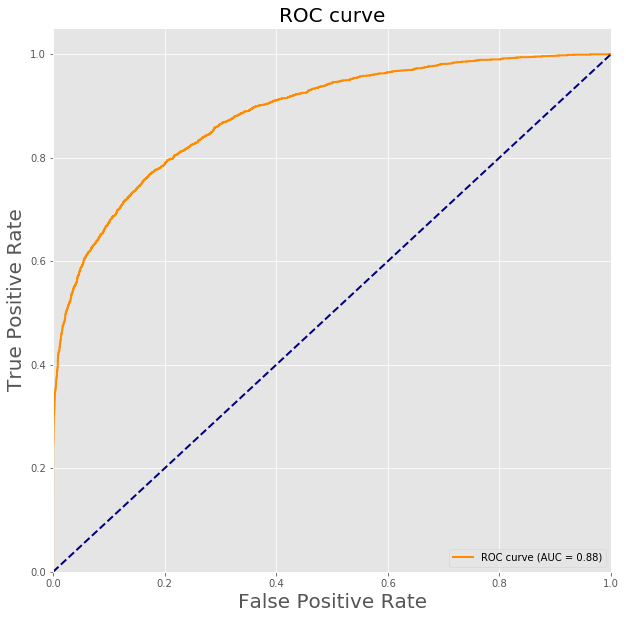

开始预测
预测结束，耗时：13.984554767608643 s
[[7272  376]
 [1043 1482]]
Accuracy: 0.860513
Precision: 0.950837
Recall: 0.874564
Specificity: 0.797632
Threshold: 0.775284
F1-Score: 0.911107


In [41]:
evaluate(model3,text_test,label_test)